In [123]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

# Get the data

In [124]:
# Read the csv and feed it into the variable xc
xc = pd.read_csv("morg-2014-emp.csv")

# Filter dataset for healthcare practitioners
xc = xc.loc[((xc["occ2012"] >= 3000) & (xc["occ2012"] <= 3540))]

C:\Users\Szabados\AppData\Local\Temp\ipykernel_13216\1807558595.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


In [125]:
# Create Variables
xc["female"] = (xc["sex"] == 2)
xc["w"] = xc["earnwke"] / xc["uhours"]
xc["lnw"] = np.log(xc["w"])
xc["agesq"] = np.power(xc["age"], 2)

In [138]:
xc['female'] = pd.to_numeric(xc['female'], errors='coerce')
xc['grade92'] = pd.to_numeric(xc['grade92'], errors='coerce')
xc['w'] = pd.to_numeric(xc['w'], errors='coerce')
xc = xc.dropna(subset=['female', 'grade92', 'w'])
xc["female"] = xc["female"].astype(int)  #from boolean to 0,1
xc["female"].value_counts()

1    7220
0    1988
Name: female, dtype: int64

# 1.: Show the unconditional gender gap

In [127]:
# Calculating average earnings for each gender
average_earnings_men = xc[xc['sex'] == 1]['earnwke'].mean()
average_earnings_women = xc[xc['sex'] == 2]['earnwke'].mean()

# Calculating the wage gap
wage_gap = average_earnings_men - average_earnings_women
wage_gap_percentage = (wage_gap / average_earnings_men) * 100

# Printing the results
print(f"Average Earnings for Men: ${average_earnings_men:.2f}")
print(f"Average Earnings for Women: ${average_earnings_women:.2f}")
print(f"Unconditional Gender Wage Gap: ${wage_gap:.2f}")
print(f"Gender Wage Gap as a Percentage of Men's Earnings: {wage_gap_percentage:.2f}%")

Average Earnings for Men: $1418.55
Average Earnings for Women: $1043.14
Unconditional Gender Wage Gap: $375.41
Gender Wage Gap as a Percentage of Men's Earnings: 26.46%


In [128]:
reg1 = smf.ols(formula="lnw~female", data=xc).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     73.17
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           1.38e-17
Time:                        17:05:34   Log-Likelihood:                -8501.1
No. Observations:                9208   AIC:                         1.701e+04
Df Residuals:                    9206   BIC:                         1.702e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3329      0.014    243.932      0.000       3.306       3.360
female[T.True]    -0.1320      0.015     -8.554      0.000      -0.162      -0.102
==============================================================================
Omnibus:                     8464.256   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1700709.478
Skew:                          -3.808   Prob(JB):                         0.00
Kurtosis:                      69.142   Cond. No.                         4.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

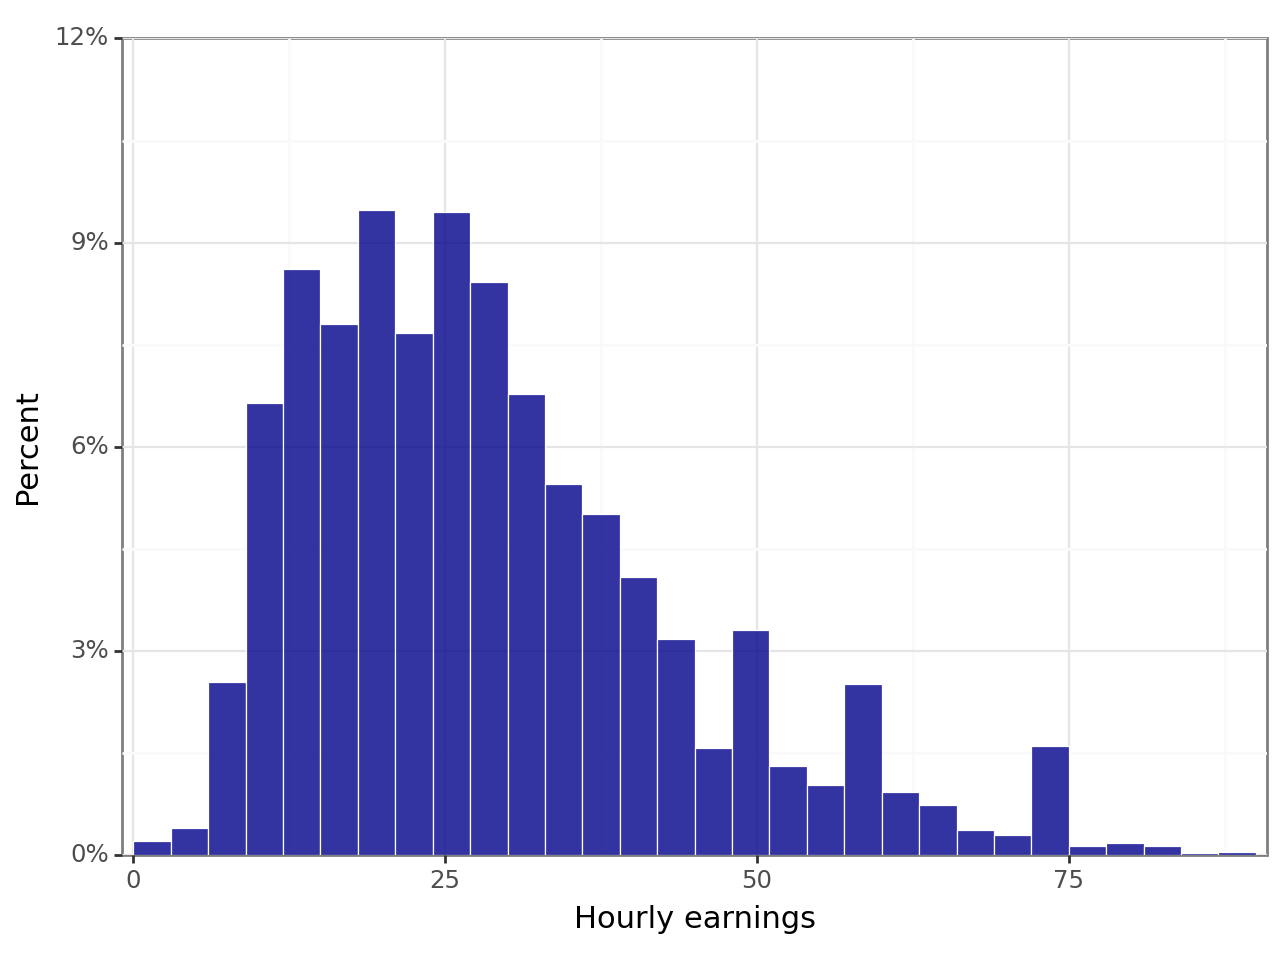

<Figure Size: (640 x 480)>

In [129]:
(
    ggplot(xc, aes(x="w", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Hourly earnings", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 90))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        limits=(0, 0.12),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


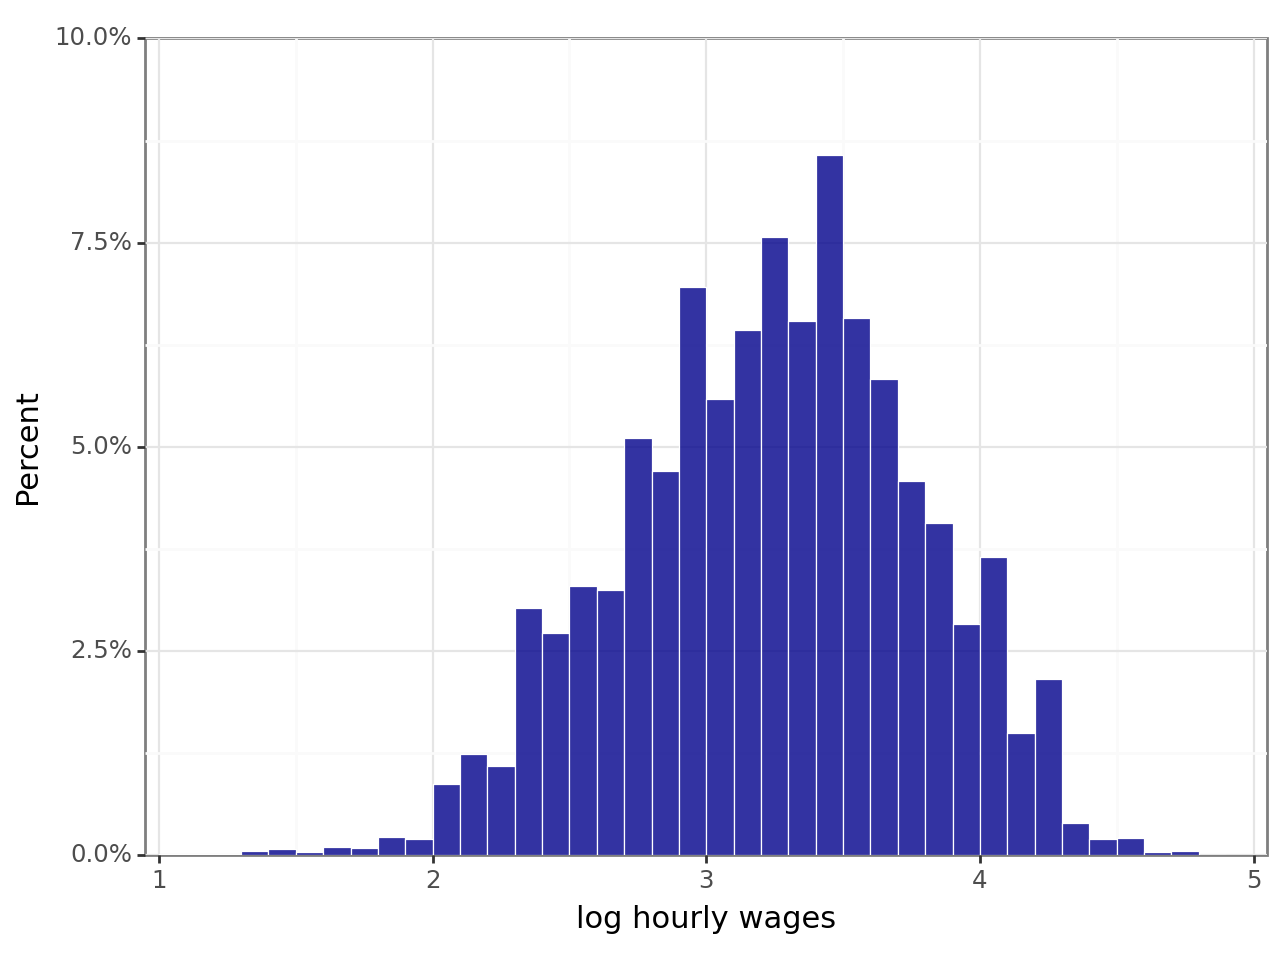

<Figure Size: (640 x 480)>

In [130]:
(
    ggplot(xc, aes(x="lnw", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        color="white",
        fill = "darkblue",
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

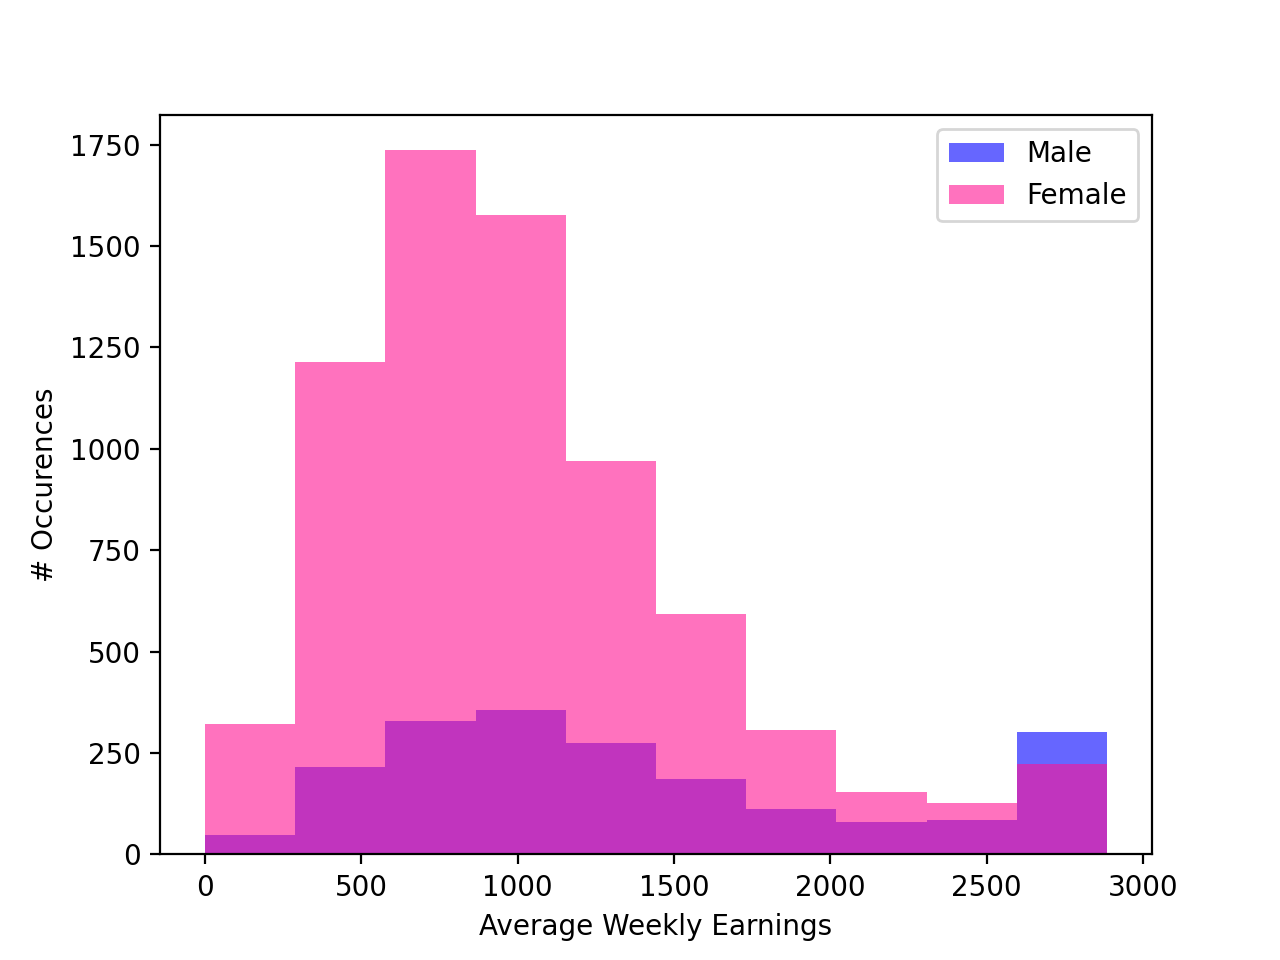

In [131]:
plt.hist(xc[xc["sex"] == 1]["earnwke"].reset_index(drop = True), alpha = 0.6, label = "Male", color = "blue")
plt.hist(xc[xc["sex"] == 2]["earnwke"].reset_index(drop = True), alpha = 0.6, label = "Female", color = "deeppink")
plt.xlabel("Average Weekly Earnings")
plt.ylabel("# Occurences")
plt.legend()
plt.show()

In [132]:
xc.loc[:, ["earnwke", "uhours", "w", "lnw"]].describe()

,earnwke,uhours,w,lnw
count,9208.000000,9208.000000,9208.000000,9208.000000
mean,1124.188752,38.541486,29.366761,3.229424
std,658.624137,9.863961,16.773557,0.611589
min,0.010000,1.000000,0.000200,-8.517193
25%,660.000000,36.000000,17.667500,2.871727
50%,980.000000,40.000000,26.000000,3.258097
75%,1420.200000,40.000000,37.393056,3.621485
max,2884.610000,99.000000,432.500000,6.069582


# 2. Show how the gender gap varies with the level of education. Consider several options to model the relationship.

## Level of Education

In [133]:
xc['BA_degree'] = (xc['grade92'] == 43).astype(int)
xc['MA_degree'] = (xc['grade92'] == 44).astype(int)
xc['Prof_degree'] = (xc['grade92'] == 45).astype(int)
xc['PhD_degree'] = (xc['grade92'] == 46).astype(int)

#Applied qualitative variables:

def EducationLvl(row):
    if row["grade92"] == 43:
        return "BA_degree"
    elif row["grade92"] == 44:
        return "MA_degree"
    elif row["grade92"] == 45:
        return "Prof_degree"
    elif row["grade92"] == 46:
        return "PhD_degree"
    else:
        return "Other"
    
xc["Education"] = xc.apply(EducationLvl, axis = 1)

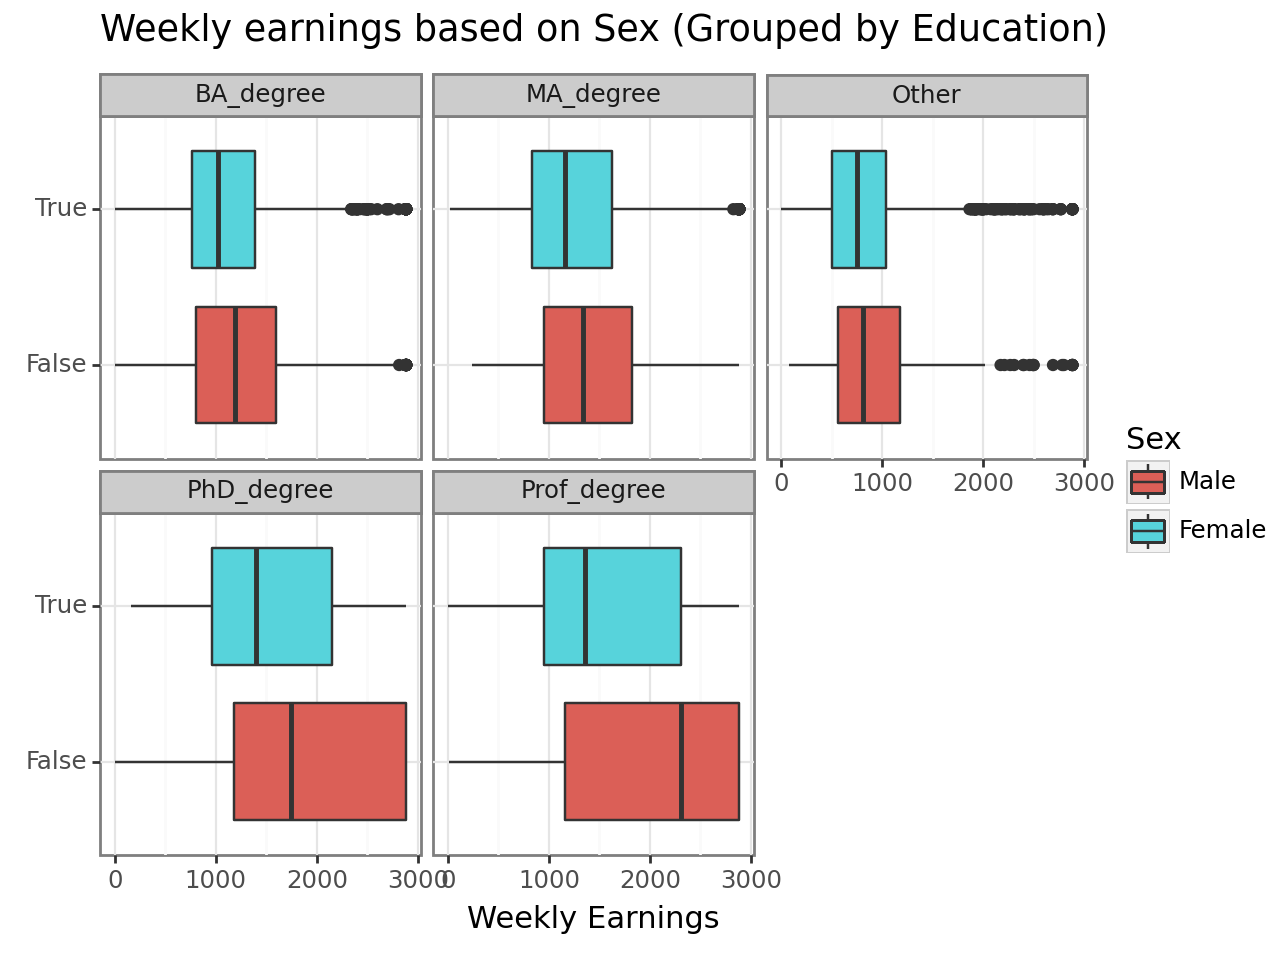

<Figure Size: (640 x 480)>

In [134]:
(
    ggplot(data = xc) + 
    aes(x = "female", y = "earnwke", fill = "female") +
    geom_boxplot() + 
    coord_flip() + 
    facet_wrap("Education") +
    theme_bw() +
    scale_fill_discrete(labels = ["Male", "Female"]) +
    labs(title = "Weekly earnings based on Sex (Grouped by Education)",x = "", y = "Weekly Earnings", fill = "Sex")
)

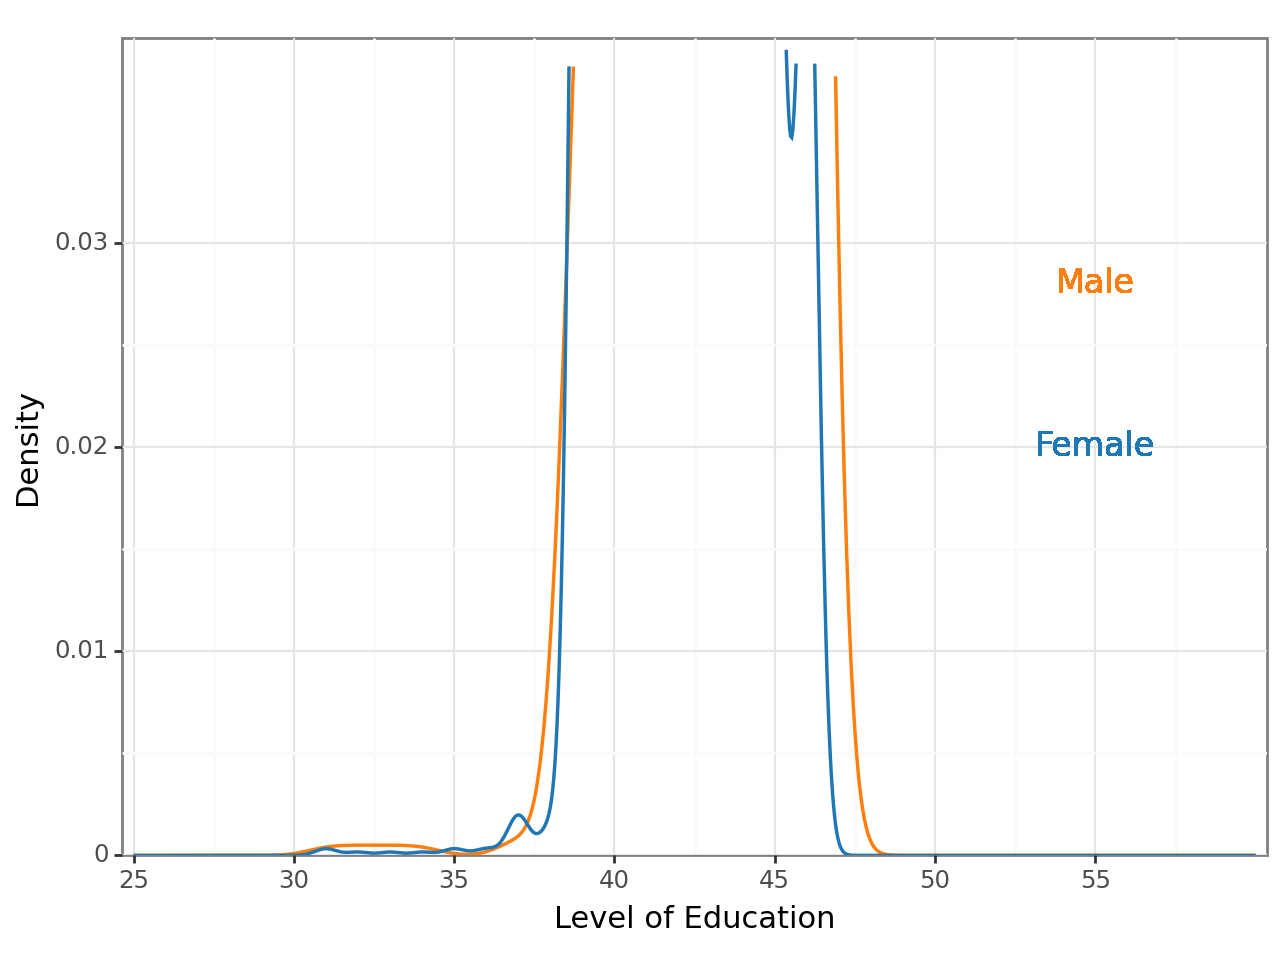

<Figure Size: (640 x 480)>

In [135]:
color = ["#1f77b4", "#ff7f0e"]

(
    ggplot(xc, aes(x="grade92", y="stat(density)", color="factor(female)"))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="Level of Education", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Male", "Female")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(25, 60), breaks=np.arange(25, 60, 5))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.04), breaks=np.arange(0, 0.04, 0.01)
    )
    + geom_text(aes(x=55, y=0.028, label="'Male'"), color=color[1], size=12)
    + geom_text(aes(x=55, y=0.020, label="'Female'"), color=color[0], size=12)
    + theme_bw()
)

In [136]:
reg6 = smf.ols(formula="lnw~female", data=xc).fit(cov_type="HC1") #unconditional
reg7 = smf.ols(formula="lnw~female+grade92", data=xc).fit(cov_type="HC1") #level of education enters linearly
reg8 = smf.ols(formula="lnw~female+grade92+BA_degree", data=xc).fit(cov_type="HC1") #add quadratic
reg9 = smf.ols(formula="lnw~female+grade92+BA_degree+MA_degree+Prof_degree", data=xc).fit(cov_type="HC1")
reg10 = smf.ols(formula="lnw~female+grade92+BA_degree+MA_degree+Prof_degree+PhD_degree", data=xc).fit(cov_type="HC1")#4-th order polynomial

In [139]:
stargazer = Stargazer([reg6, reg7, reg8, reg9, reg10])
stargazer.covariate_order(["female", "grade92", "BA_degree", "MA_degree", "Prof_degree", "PhD_degree", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

AssertionError: Covariate order must contain subset of existing covariates: {'female'} are not.

In [ ]:
# PREDICTION AND GRAPH POLYNOMIAL
# male
data_m = xc.query("female==0")

pred = reg16.predict(data_m)

pred = reg16.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

# female
data_f = xc.query("female==1")

pred = reg16.predict(data_f)

pred = reg16.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]

In [140]:
(
    ggplot(data_m, aes(x="grade92", y="fit"))
    + geom_line(colour=color[0])
    + geom_line(data_m, aes(x="grade92", y="CIup"), colour=color[0], linetype="dashed")
    + geom_line(data_m, aes(x="grade92", y="CIlo"), colour=color[0], linetype="dashed")
    + geom_line(data_f, aes(x="grade92", y="fit"), colour=color[1])
    + geom_line(data_f, aes(x="grade92", y="CIup"), colour=color[1], linetype="dashed")
    + geom_line(data_f, aes(x="grade92", y="CIlo"), colour=color[1], linetype="dashed")
    + labs(x="Level of Education", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=np.arange(25, 65, 5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=np.arange(2.8, 3.8, 0.1)
    )
    + theme_bw()
)

NameError: name 'data_m' is not defined